# Assessing the Trained Model's Performance on the Test Set

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from src.engine import biLSTM_engine, ResNet50_GRU_engine, MTL_engine
from src.model_transportMode import BiLSTMNetwork
from src.model_driverID import ResNet50_GRU
from src.model_multitask import MultitaskModel
from src.dataset import TransportModeDataset, FeatureMapDatasetImproved, CombinedDataset


from torch.utils.data import DataLoader

In [2]:
lstm_base_dir = './data/lstm_features_labels/'
fmap_base_dir = './data/feature_maps_labels/'
np.random.seed(42)

test_datasets_mtl = CombinedDataset(fmap_base_dir, lstm_base_dir, mode='test', 
                                 rescale=False, augment=True)
test_datasets_trp = TransportModeDataset(lstm_base_dir, mode='test')
test_datasets_drv = FeatureMapDatasetImproved(fmap_base_dir, mode='test', rescale=False, augment=True)


mtl_test_dl = DataLoader(test_datasets_mtl, batch_size=128, shuffle=False, num_workers=2)
trp_test_dl = DataLoader(test_datasets_trp, batch_size=64, shuffle=False, num_workers=2)
drv_test_dl = DataLoader(test_datasets_drv, batch_size=32, shuffle=False, num_workers=2)

In [3]:
criterion_driver = nn.CrossEntropyLoss()
criterion_transport = nn.CrossEntropyLoss()

mtl_model = MultitaskModel(input_size=6, hidden_size=1024, num_layers=1, dropout=0.6409051706390204)
mtl_optimizer = optim.AdamW(mtl_model.parameters(), lr=0.0005392288692948486, weight_decay=0.0422480267454383)
mtl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(mtl_optimizer, factor=0.13618183112843046, patience=10)

trp_model = BiLSTMNetwork(input_size=6, hidden_size=300, num_layers=1, dropout=0.494697) #drop is technically == 0 since n_layers == 1
trp_optimizer = optim.AdamW(trp_model.parameters(), lr=0.00769697, weight_decay=0.0756331)
trp_scheduler = optim.lr_scheduler.ExponentialLR(trp_optimizer, gamma=0.931817)

drv_model = ResNet50_GRU(hidden_size=1024, num_layers=2, dropout=0.7, unfreeze_L3=True, unfreeze_L4=True)
drv_optimizer = optim.Adam(drv_model.parameters(), lr=0.00132603, weight_decay=0.00111036)
drv_scheduler = optim.lr_scheduler.ExponentialLR(drv_optimizer, gamma=0.304855)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mtl_model = mtl_model.to(device)
trp_model = trp_model.to(device)
drv_model = drv_model.to(device)

In [4]:
device

device(type='cuda')

### Load saved models

In [5]:
trp_checkpoint = torch.load('./model_checkpoint/run2_transpMode_BiLSTM_chkpt.pth_epoch_40.pt')
drv_checkpoint = torch.load('./model_checkpoint/run3_driver1D_ResNet50GRU_chkpt.pth_epoch_30.pt')
mtl_checkpoint = torch.load('./model_checkpoint/run1_MTL_model_chkpt.pth_epoch_50.pt')

trp_model.load_state_dict(trp_checkpoint['model_state_dict'])
drv_model.load_state_dict(drv_checkpoint['model_state_dict'])
mtl_model.load_state_dict(mtl_checkpoint['model_state_dict'])

<All keys matched successfully>

### Calculate Test Accuracies

In [6]:
mtl_engine = MTL_engine(mtl_model, mtl_optimizer, mtl_scheduler, criterion_driver, criterion_transport, device)
trp_engine = biLSTM_engine(trp_model, trp_optimizer, trp_scheduler, criterion_transport, device)
drv_engine = ResNet50_GRU_engine(drv_model, drv_optimizer, drv_scheduler, criterion_driver, device)

Test time: 1min 14.8s

In [7]:
print('Transport Class Acc:')
_ = trp_engine.test(trp_test_dl)

Transport Class Acc:
Test Loss: 0.5281, Test Accuracy: 82.34%


Test time: 2min 5.9s

In [8]:
print('Driver Id Acc:')
_ = drv_engine.test(drv_test_dl)

Driver Id Acc:
Test Accuracy: 0.748287552757213


Test time: 2min 39.1s

In [9]:
print('MTL Class Acc:')
_ = mtl_engine.test(mtl_test_dl, criterion_transport, criterion_driver, alpha=1, beta=1)

MTL Class Acc:
   Test Loss: 0.6319, Test Transport Accuracy: 88.24%, Test Driver Accuracy: 95.76%


### Calculating Precision, Recall and F1 score

In [10]:
from sklearn.preprocessing import label_binarize

time = 1min 52.1s

In [11]:
drv_all_probs, drv_all_labels = drv_engine.test_return_pred(drv_test_dl)

time = 53.6s

In [12]:
trp_all_probs, trp_all_labels = trp_engine.test_return_pred(trp_test_dl)

time = 1m 37.3

In [13]:
MTL_all_probs_TRP, MTL_all_labels_TRP, MTL_all_probs_DRV, MTL_all_labels_DRV = mtl_engine.test_return_pred(mtl_test_dl)

In [14]:
# get number of classes
drv_num_classes = len(np.unique(drv_all_labels))
drv_classes = np.array(['Not_driving', 'User1', 'User2', 'User3'])
trp_num_classes = len(np.unique(trp_all_labels))
trp_classes = np.array(['Still', 'Walking', 'Run', 'Bike', 'Car', 'Bus', 'Train', 'Subway'])

# Convert labels to a binary format for each class (One-vs-Rest)
drv_all_labels_bin = label_binarize(drv_all_labels, classes=list(range(drv_num_classes)))
trp_all_labels_bin = label_binarize(trp_all_labels, classes=list(range(trp_num_classes)))
MTL_drv_all_labels_bin = label_binarize(MTL_all_labels_DRV, classes=list(range(drv_num_classes)))
MTL_trp_all_labels_bin = label_binarize(MTL_all_labels_TRP, classes=list(range(trp_num_classes)))

**Calculate the Precision-Recall for each class for task**

In [15]:
from src.metrics import calc_metrics

In [16]:
drv_prec, drv_rec, drv_f1 = calc_metrics(drv_all_probs, drv_all_labels_bin, drv_num_classes)
trp_prec, trp_rec, trp_f1 = calc_metrics(trp_all_probs, trp_all_labels_bin, trp_num_classes)
MTL_drv_prec, MTL_drv_rec, MTL_drv_f1 = calc_metrics(MTL_all_probs_DRV, MTL_drv_all_labels_bin, drv_num_classes)
MTL_trp_prec, MTL_trp_rec, MTL_trp_f1 = calc_metrics(MTL_all_probs_TRP, MTL_trp_all_labels_bin, trp_num_classes)

In [17]:
from src.plot import plot_precRec_curve, plot_F1rec_curve, plot_learning_curve, plot_accuracy

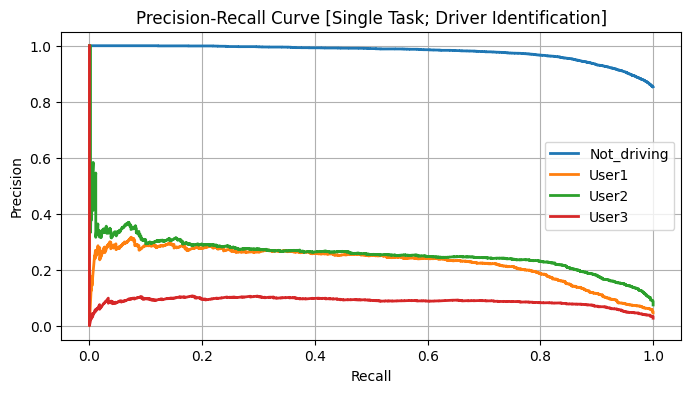

In [18]:
plot_precRec_curve(drv_prec, drv_rec, drv_classes, drv_num_classes, title="Precision-Recall Curve [Single Task; Driver Identification]")

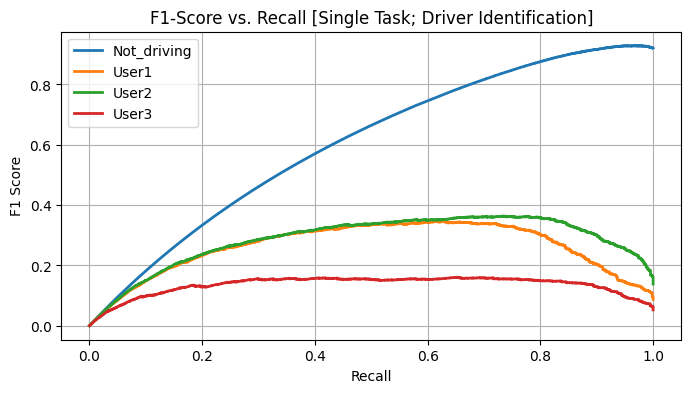

In [19]:
plot_F1rec_curve(drv_rec, drv_f1, drv_classes, drv_num_classes, title="F1-Score vs. Recall [Single Task; Driver Identification]")

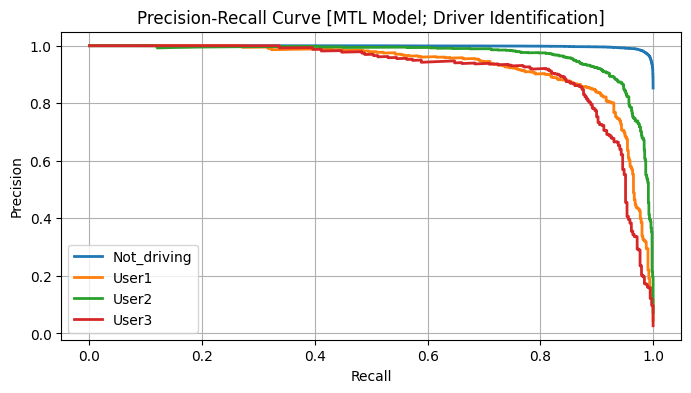

In [20]:
plot_precRec_curve(MTL_drv_prec, MTL_drv_rec, drv_classes, drv_num_classes, title="Precision-Recall Curve [MTL Model; Driver Identification]")

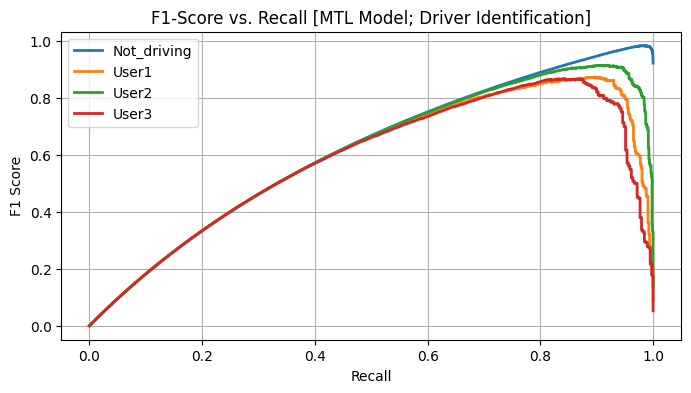

In [21]:
plot_F1rec_curve(MTL_drv_rec, MTL_drv_f1, drv_classes, drv_num_classes, title="F1-Score vs. Recall [MTL Model; Driver Identification]")

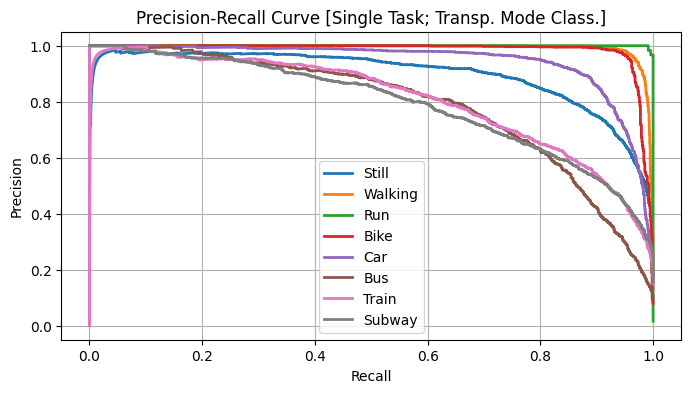

In [22]:
plot_precRec_curve(trp_prec, trp_rec, trp_classes, trp_num_classes, title="Precision-Recall Curve [Single Task; Transp. Mode Class.]")

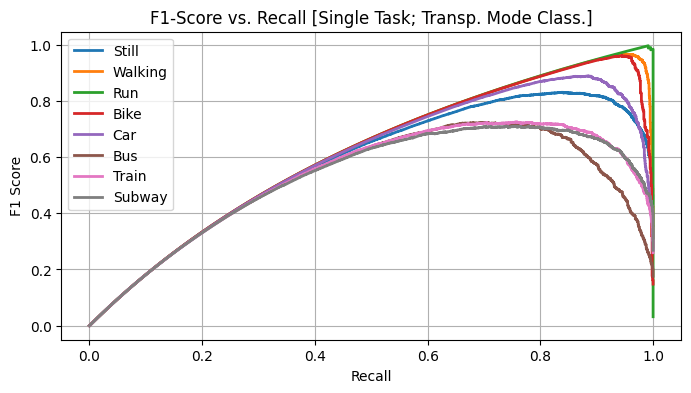

In [23]:
plot_F1rec_curve(trp_rec, trp_f1, trp_classes, trp_num_classes, title="F1-Score vs. Recall [Single Task; Transp. Mode Class.]")

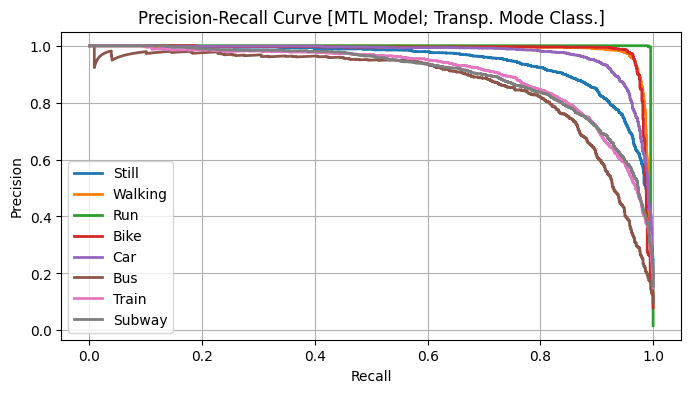

In [24]:
plot_precRec_curve(MTL_trp_prec, MTL_trp_rec, trp_classes, trp_num_classes, title="Precision-Recall Curve [MTL Model; Transp. Mode Class.]")

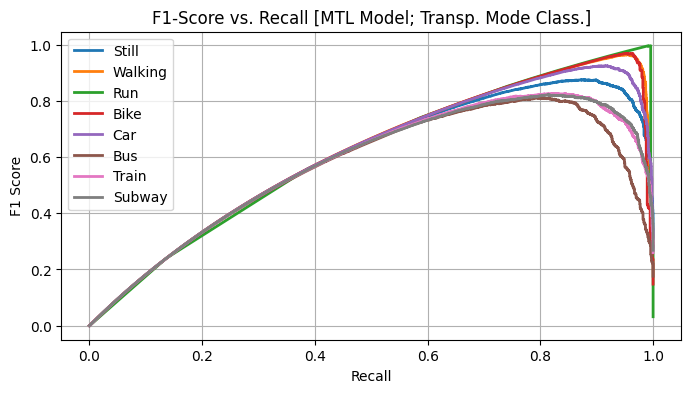

In [25]:
plot_F1rec_curve(MTL_trp_rec, MTL_trp_f1, trp_classes, trp_num_classes, title="F1-Score vs. Recall [MTL Model; Transp. Mode Class.]")

**Plotting Learning Curves and Accuracy Curves**

In [26]:
from src.utils import read_Hist

In [27]:
drv_list = ["./model_checkpoint/seed_192_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_117_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_47_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/seed_172_driver1D_ResNet50GRU_history.npy",
            "./model_checkpoint/run3_driver1D_ResNet50GRU_history.npy"]

trp_hist = ["./model_checkpoint/seed_192_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_117_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_47_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/seed_172_transpMode_BiLSTM_history.npy",
            "./model_checkpoint/run2_40epochs_transpMode_BiLSTM_history.npy"]

MTL_hist = ["./model_checkpoint/seed_47_MTL_model_history.npy",
            "./model_checkpoint/seed_172_MTL_model_history.npy",
            "./model_checkpoint/run1_MTL_model_history.npy",
            "./model_checkpoint/seed_192_MTL_model_history.npy",
            "./model_checkpoint/seed_117_MTL_model_history.npy"]

DRV_tr_loss, DRV_tr_acc, DRV_val_loss, DRV_val_acc = read_Hist().get_trVal_loss_acc(drv_list)
TRP_tr_loss, TRP_tr_acc, TRP_val_loss, TRP_val_acc = read_Hist().get_trVal_loss_acc(trp_hist)
MTL_tr_loss, MTL_tr_acc_TRP, MTL_tr_acc_DRV, MTL_val_loss, MTL_val_acc_TRP, MTL_val_acc_DRV = read_Hist().get_trVal_loss_acc(MTL_hist, MTL=True)

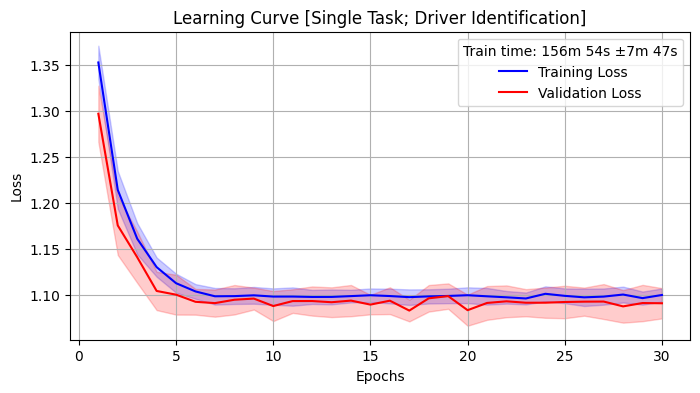

In [28]:
plot_learning_curve(DRV_tr_loss, DRV_val_loss, title='Learning Curve [Single Task; Driver Identification]', legend_text='Train time: 156m 54s ±7m 47s')

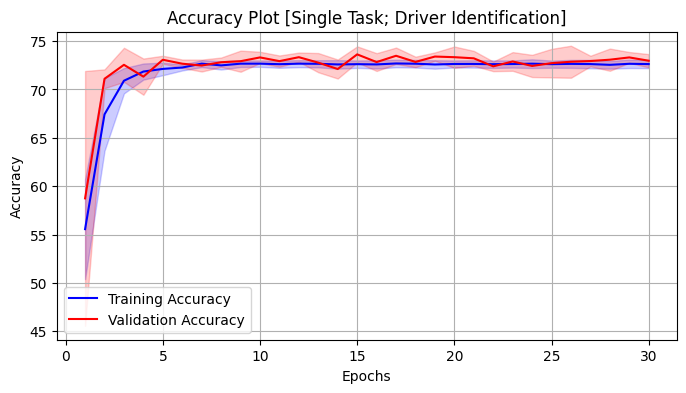

In [29]:
plot_accuracy(DRV_tr_acc, DRV_val_acc, title='Accuracy Plot [Single Task; Driver Identification]', legend_text='')

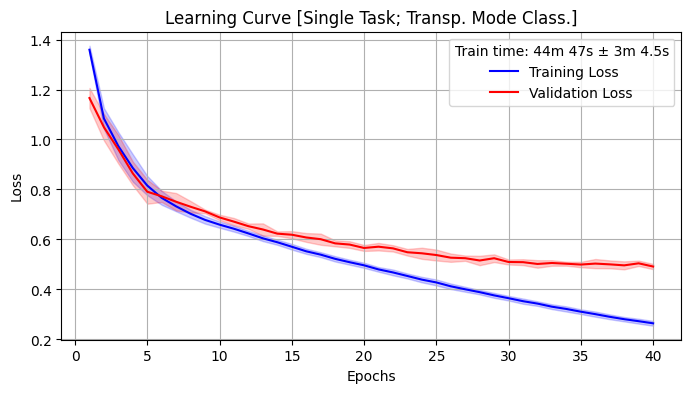

In [30]:
plot_learning_curve(TRP_tr_loss, TRP_val_loss, title='Learning Curve [Single Task; Transp. Mode Class.]', legend_text='Train time: 44m 47s ± 3m 4.5s')

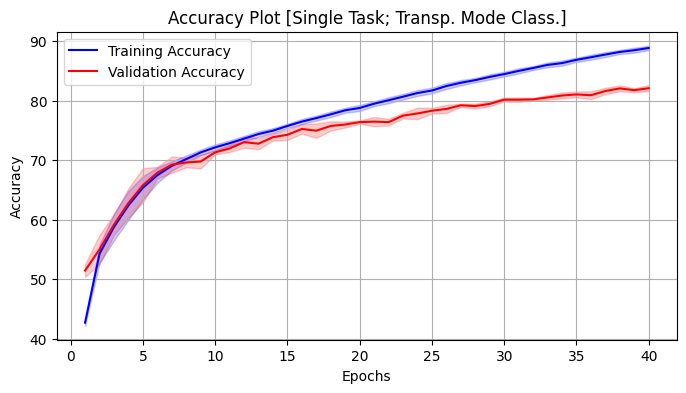

In [31]:
plot_accuracy(TRP_tr_acc, TRP_val_acc, title='Accuracy Plot [Single Task; Transp. Mode Class.]', legend_text='')

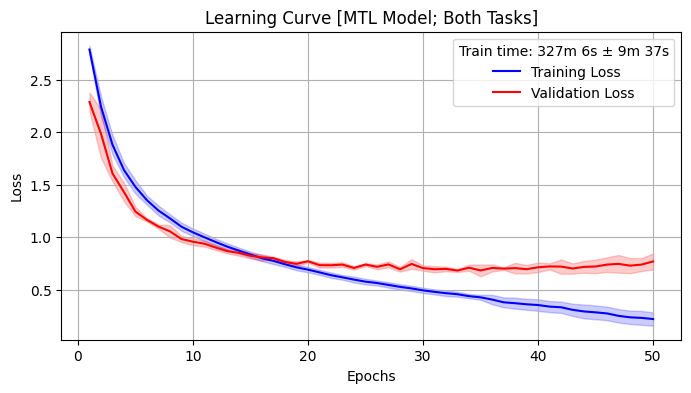

In [32]:
plot_learning_curve(MTL_tr_loss, MTL_val_loss, title='Learning Curve [MTL Model; Both Tasks]', legend_text='Train time: 327m 6s ± 9m 37s')

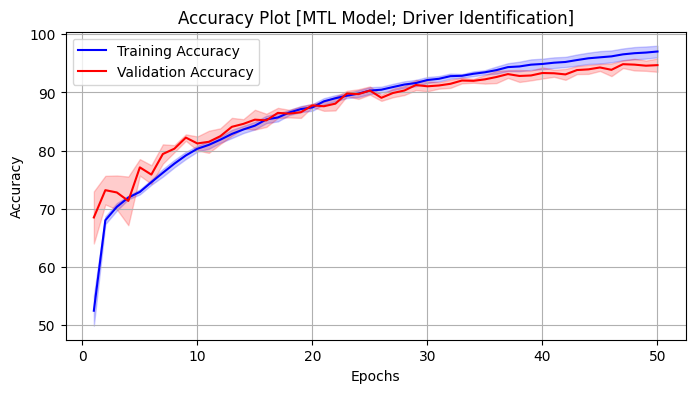

In [33]:
plot_accuracy(MTL_tr_acc_DRV, MTL_val_acc_DRV, title='Accuracy Plot [MTL Model; Driver Identification]', legend_text='')

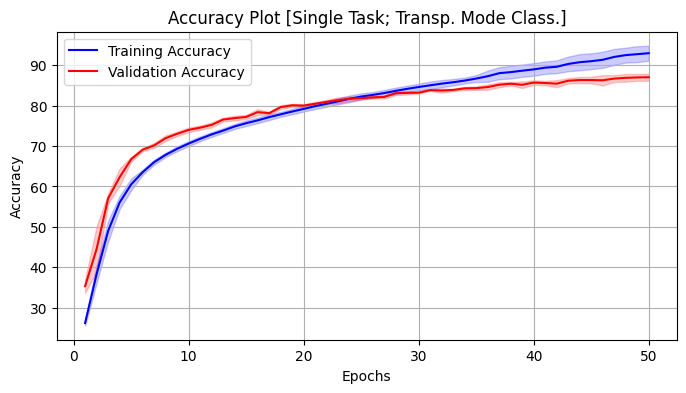

In [34]:
plot_accuracy(MTL_tr_acc_TRP, MTL_val_acc_TRP, title='Accuracy Plot [Single Task; Transp. Mode Class.]', legend_text='')